In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
from plot_result import plot_result

In [2]:
df=pd.read_csv("../../data/merged/len3_prod_mon_agg_drop_never.csv",encoding="shift-jis",index_col=0)
df["prod_date"]

C:\Users\hakos\AppData\Local\Temp\ipykernel_3484\3490194615.py:1: DtypeWarning: Columns (5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("../../data/merged/len3_prod_mon_agg_drop_never.csv",encoding="shift-jis",index_col=0)


0       2009-01-31
1       2009-02-28
2       2009-03-31
3       2009-04-30
4       2009-05-31
           ...    
4194    2022-08-31
4195    2022-09-30
4196    2022-10-31
4197    2022-11-30
4198    2022-12-31
Name: prod_date, Length: 4199, dtype: object

Estimation

In [3]:
df=pd.concat([df,pd.get_dummies(df["month"],prefix="mon")],axis=1)
df["mon_1"]

0       1
1       0
2       0
3       0
4       0
       ..
4194    0
4195    0
4196    0
4197    0
4198    0
Name: mon_1, Length: 4199, dtype: uint8

In [4]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#前処理
df.replace('-',"0",inplace=True)
df["otc_pro_agg"].replace(",","",regex=True,inplace=True)
df["rx_pro_agg"].replace(",","",regex=True,inplace=True)
# df["stock_otc_lag"].replace(",","",regex=True,inplace=True)
# df["stock_rx_lag"].replace(",","",regex=True,inplace=True)
# fillna
df["otc_pro_agg"].fillna(0,inplace=True)
df["rx_pro_agg"].fillna(0,inplace=True)
# df["stock_otc_lag"].fillna(0,inplace=True)
# df["stock_rx_lag"].fillna(0,inplace=True)

df["otc_pro_agg"]=df["otc_pro_agg"].astype(int)
df["rx_pro_agg"]=df["rx_pro_agg"].astype(int)
# df["stock_otc_lag"]=df["stock_otc_lag"].astype(int)
# df["stock_rx_lag"]=df["stock_rx_lag"].astype(float)
#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_pro_agg"]>0]
df=df.loc[df["rx_pro_agg"]>0]
# df=df.loc[df["stock_otc_lag"]>0]
# df=df.loc[df["stock_rx_lag"]>0]

# make log columns
df["log_rx_pro_agg"]=np.log(df["rx_pro_agg"])
df["log_otc_pro_agg"]=np.log(df["otc_pro_agg"])
# df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"])
# df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"])

# make year trend
df["year_trend"]=df["year"]-2008

In [5]:
# change to the datetime format
df['prod_date'] = pd.to_datetime(df["prod_date"], format='%Y-%m-%d')
# df=df.set_index(["id","prod_date"])
df=df.set_index(["id","year"])

df.info()
# make this to paneldata
df=PanelData(df,convert_dummies=False)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2553 entries, (114, 2009) to (799, 2022)
Columns: 639 entries, month to year_trend
dtypes: datetime64[ns](1), float64(11), int32(2), int64(601), object(12), uint8(12)
memory usage: 12.2+ MB


(639, 14, 21)

In [6]:
months="+mon_1+mon_2+mon_3+mon_4+mon_5+mon_6+mon_7+mon_8+mon_9+mon_10+mon_11+mon_12"
ytrend="+year_trend"

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

## RX

In [7]:
before_p=10*12
after_p=15*12
elapsed = ''.join(["+elapsed_m" + str(i) for i in range(before_p, 1, -1)])
elapsed=elapsed+''.join(["+elapsed_" + str(i) for i in range(0,after_p+1)])
print(elapsed)


+elapsed_m120+elapsed_m119+elapsed_m118+elapsed_m117+elapsed_m116+elapsed_m115+elapsed_m114+elapsed_m113+elapsed_m112+elapsed_m111+elapsed_m110+elapsed_m109+elapsed_m108+elapsed_m107+elapsed_m106+elapsed_m105+elapsed_m104+elapsed_m103+elapsed_m102+elapsed_m101+elapsed_m100+elapsed_m99+elapsed_m98+elapsed_m97+elapsed_m96+elapsed_m95+elapsed_m94+elapsed_m93+elapsed_m92+elapsed_m91+elapsed_m90+elapsed_m89+elapsed_m88+elapsed_m87+elapsed_m86+elapsed_m85+elapsed_m84+elapsed_m83+elapsed_m82+elapsed_m81+elapsed_m80+elapsed_m79+elapsed_m78+elapsed_m77+elapsed_m76+elapsed_m75+elapsed_m74+elapsed_m73+elapsed_m72+elapsed_m71+elapsed_m70+elapsed_m69+elapsed_m68+elapsed_m67+elapsed_m66+elapsed_m65+elapsed_m64+elapsed_m63+elapsed_m62+elapsed_m61+elapsed_m60+elapsed_m59+elapsed_m58+elapsed_m57+elapsed_m56+elapsed_m55+elapsed_m54+elapsed_m53+elapsed_m52+elapsed_m51+elapsed_m50+elapsed_m49+elapsed_m48+elapsed_m47+elapsed_m46+elapsed_m45+elapsed_m44+elapsed_m43+elapsed_m42+elapsed_m41+elapsed_m40+elapse

                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
elapsed_m120       -0.0691     0.1158    -0.5967     0.5507     -0.2961      0.1579
elapsed_m119        0.0309     0.1310     0.2359     0.8136     -0.2261      0.2879
elapsed_m118       -0.2137     0.1377    -1.5522     0.1208     -0.4836      0.0563
elapsed_m117       -0.2156     0.1397    -1.5435     0.1229     -0.4895      0.0583
elapsed_m116       -0.1594     0.1649    -0.9663     0.3340     -0.4828      0.1641
elapsed_m115       -0.4368     0.2837    -1.5395     0.1238     -0.9933      0.1196
elapsed_m114       -0.3612     0.3579    -1.0091     0.3131     -1.0631      0.3408
elapsed_m113       -0.2206     0.1560    -1.4139     0.1575     -0.5266      0.0854
elapsed_m112       -0.0399     0.1625    -0.2452     0.8063     -0.3586     

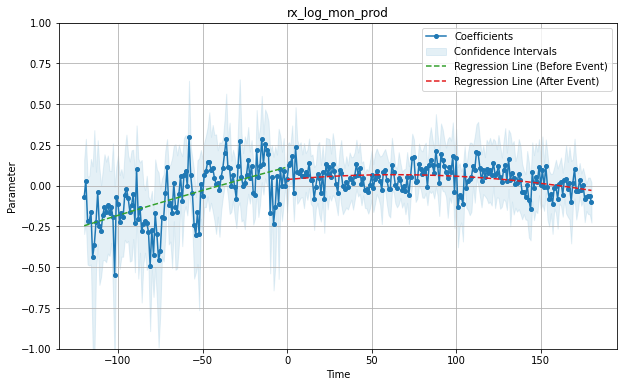

In [8]:
# take log
formula="log_rx_pro_agg ~ "+elapsed


# log_stock_rx_lag
# formula+=" + log_stock_rx_lag"
# ytrend
# formula+=ytrend
# months
formula+=months
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"
# fixed effects
formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True,check_rank=False)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="rx_log_mon_prod",title="rx_log_mon_prod",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)

### OTC

                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
elapsed_m120        0.1163     0.4619     0.2518     0.8012     -0.7895      1.0222
elapsed_m119        0.4781     0.4137     1.1556     0.2480     -0.3332      1.2894
elapsed_m118       -0.0337     0.6750    -0.0499     0.9602     -1.3574      1.2901
elapsed_m117       -0.6273     0.7336    -0.8551     0.3926     -2.0660      0.8113
elapsed_m116        0.3068     0.4465     0.6872     0.4920     -0.5687      1.1823
elapsed_m115        0.2815     0.4432     0.6352     0.5253     -0.5876      1.1506
elapsed_m114        0.4370     0.4258     1.0264     0.3048     -0.3979      1.2719
elapsed_m113        0.3377     0.3846     0.8780     0.3800     -0.4165      1.0920
elapsed_m112        0.7915     0.3547     2.2315     0.0257      0.0959     

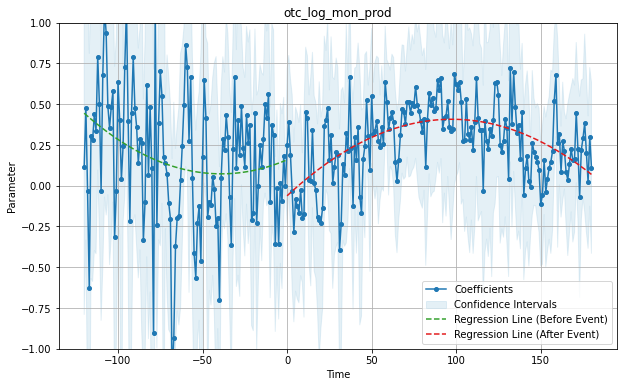

In [9]:
# take log

# till 20
# formula="log_otc_pro_agg ~ elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+elapsed_16+elapsed_17+elapsed_18+elapsed_19+elapsed_20+generic_per+TimeEffects+EntityEffects"

# take log
formula="log_otc_pro_agg ~ "+elapsed


# log_stock_rx_lag
# formula+=" + log_otc_rx_lag"
# ytrend
# formula+=ytrend
# months
formula+=months
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"

formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
# print(res_fe)
plot_result(res_fe,file_name="otc_log_mon_prod",title="otc_log_mon_prod",ylim=(-1,1),plot_type="o-",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)

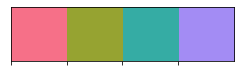

In [10]:
import seaborn as sns

# 視認性の良い4つの色を生成
colors = sns.color_palette('husl', 4)

# カラーマップを表示
sns.palplot(colors)
